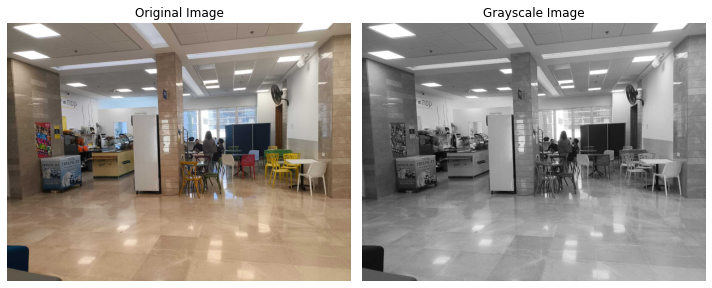

In [2]:
# 1.a 
import cv2
import matplotlib.pyplot as plt

# Load the original image
original_image = cv2.imread('../my_data/cafeteria.jpg')  # Update with the image path
if original_image is None:
    print("Error: Image not found! Ensure it's in the correct directory.") # Self check 
else:
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Ensure the grayscale image is in uint8 format
    grayscale_image = grayscale_image.astype('uint8')

    # Display both the original and grayscale images
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Grayscale image
    plt.subplot(1, 2, 2)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

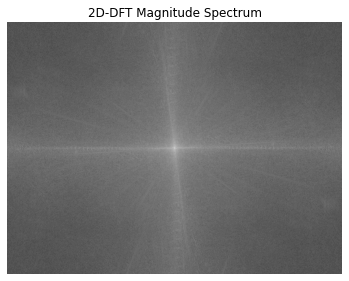

In [3]:
# 1.b
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Perform 2D Discrete Fourier Transform (DFT)
dft = cv2.dft(np.float32(grayscale_image), flags=cv2.DFT_COMPLEX_OUTPUT)

# Shift the zero-frequency component to the center
dft_shift = np.fft.fftshift(dft)

# Compute the magnitude spectrum
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

# Display the magnitude spectrum
plt.figure(figsize=(6, 6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("2D-DFT Magnitude Spectrum")
plt.axis('off')
plt.show()

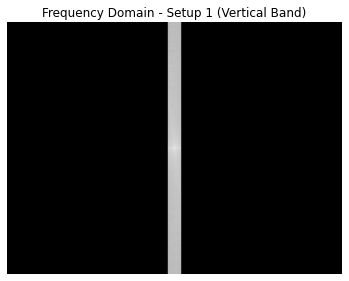

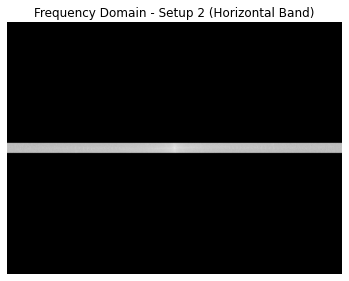

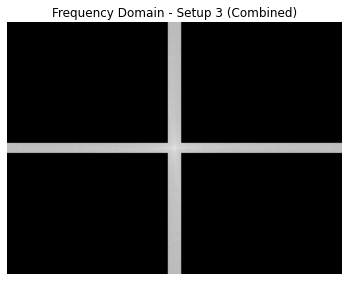

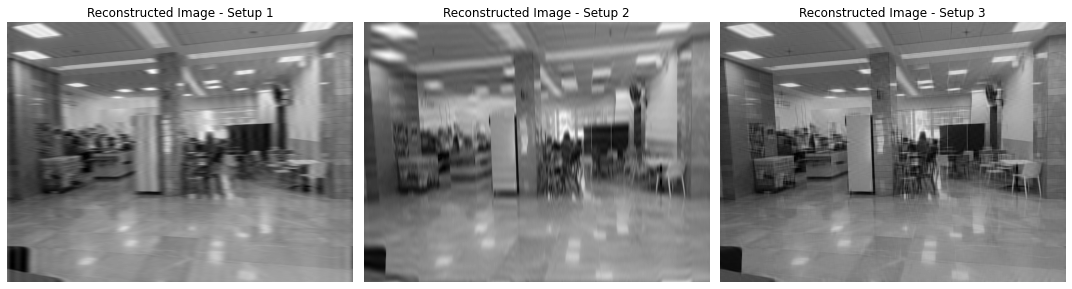

In [37]:
# 1.c
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Perform 2D-DFT and center frequencies
dft = cv2.dft(np.float32(grayscale_image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Get image dimensions
rows, cols = grayscale_image.shape
crow, ccol = rows // 2, cols // 2

# Define 2% band
band_width_row = int(0.02 * rows)
band_width_col = int(0.02 * cols)

# Create masks for the setups
mask1 = np.zeros((rows, cols, 2), np.uint8)
mask1[:, ccol - band_width_col:ccol + band_width_col, :] = 1  # Vertical band (focuses on l index)

mask2 = np.zeros((rows, cols, 2), np.uint8)
mask2[crow - band_width_row:crow + band_width_row, :, :] = 1  # Horizontal band (focuses on k index)

mask3 = mask1 | mask2  # Logical OR of masks 1 and 2

# Apply the masks
filtered1 = dft_shift * mask1
filtered2 = dft_shift * mask2
filtered3 = dft_shift * mask3

# Display results in frequency domain
def display_frequency(magnitude_spectrum, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def get_magnitude_spectrum(dft_result):
    return 20 * np.log(cv2.magnitude(dft_result[:, :, 0], dft_result[:, :, 1]) + 1e-8)
# Note: Adding 1e-8 ensures there are no zeros in the magnitude values, so the logarithm is well-defined


display_frequency(get_magnitude_spectrum(filtered1), "Frequency Domain - Setup 1 (Vertical Band)")
display_frequency(get_magnitude_spectrum(filtered2), "Frequency Domain - Setup 2 (Horizontal Band)")
display_frequency(get_magnitude_spectrum(filtered3), "Frequency Domain - Setup 3 (Combined)")

# Perform Inverse 2D-DFT
def inverse_dft(filtered):
    idft_shift = np.fft.ifftshift(filtered)
    img_back = cv2.idft(idft_shift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    return img_back

reconstructed1 = inverse_dft(filtered1)
reconstructed2 = inverse_dft(filtered2)
reconstructed3 = inverse_dft(filtered3)

# Display reconstructed images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(reconstructed1, cmap='gray')
plt.title("Reconstructed Image - Setup 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed2, cmap='gray')
plt.title("Reconstructed Image - Setup 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed3, cmap='gray')
plt.title("Reconstructed Image - Setup 3")
plt.axis('off')

plt.tight_layout()
plt.show()

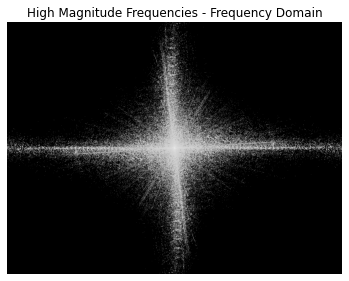

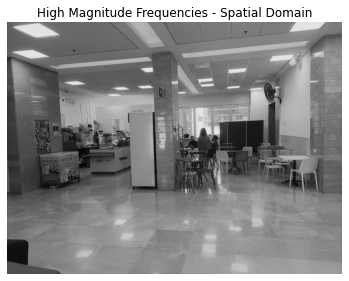

In [39]:
# 1.d + 1.e (1.e repeats this code while calling the function with percentage=4)
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the max_freq_filtering function
def max_freq_filtering(fshift, percentage):
    """
    Reconstruct an image using only its maximal amplitude frequencies.
    :param fshift: The fft of an image, **after fftshift** - complex float ndarray of size [H x W].
    :param percentage: The wanted percentage of frequencies of highest amplitude.
    :return:
        fMaxFreq: The filtered frequency domain result - complex float ndarray of size [H x W].
        imgMaxFreq: The filtered image - real float ndarray of size [H x W].
    """
    # Calculate the amplitude spectrum
    magnitude = cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1])
    
    # Flatten and sort by amplitude
    flat_magnitude = magnitude.flatten() # Transfering 2D array to 1D
    total_pixels = len(flat_magnitude)   # Total number of pixels in the freq domain
    threshold_index = int(total_pixels * (percentage / 100)) # Determines the number of pixels to retain
    sorted_indices = np.argsort(flat_magnitude)[::-1]  # Sort in descending order
    
    # Create a mask to retain all top 10% frequencies
    mask = np.zeros_like(flat_magnitude, dtype=bool)
    top_indices = sorted_indices[:threshold_index]
    mask[top_indices] = True
    mask = mask.reshape(magnitude.shape)
    
    # Create a filtered frequency-domain image
    fMaxFreq = np.zeros_like(fshift)
    fMaxFreq[:, :, 0] = fshift[:, :, 0] * mask
    fMaxFreq[:, :, 1] = fshift[:, :, 1] * mask
    
    # Perform the inverse shift and inverse DFT
    fMaxFreq_ishift = np.fft.ifftshift(fMaxFreq)
    imgMaxFreq = cv2.idft(fMaxFreq_ishift)
    imgMaxFreq = cv2.magnitude(imgMaxFreq[:, :, 0], imgMaxFreq[:, :, 1])  # Get real values
    
    return fMaxFreq, imgMaxFreq
# Apply the function with percentage=10
fMaxFreq, imgMaxFreq = max_freq_filtering(dft_shift, 10)

# Display the result in the frequency domain
def display_frequency(magnitude_spectrum, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

display_frequency(20 * np.log(cv2.magnitude(fMaxFreq[:, :, 0], fMaxFreq[:, :, 1]) + 1e-8), 
                  "High Magnitude Frequencies - Frequency Domain")

# Display the result in the spatial domain
plt.figure(figsize=(6, 6))
plt.imshow(imgMaxFreq, cmap='gray')
plt.title("High Magnitude Frequencies - Spatial Domain")
plt.axis('off')
plt.show()

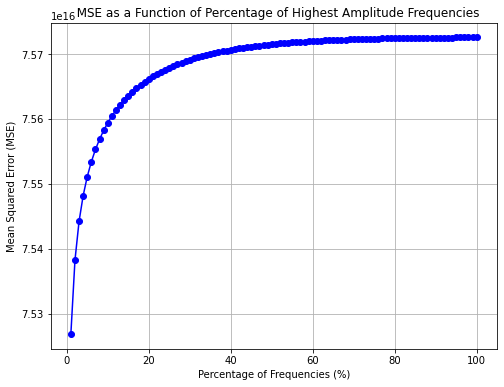

In [40]:
# 1.f
import numpy as np
import matplotlib.pyplot as plt

# Assume grayscale_image and dft_shift are already defined

# Function to calculate MSE
def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

# List to store MSE values
mse_values = []

# Range of percentages (1% to 100%)
percentages = range(1, 101)

# Loop through percentages and calculate MSE
for p in percentages:
    # Reconstruct image using max_freq_filtering
    _, reconstructed_image = max_freq_filtering(dft_shift, p)
    
    # Calculate MSE
    mse = calculate_mse(grayscale_image, reconstructed_image)
    mse_values.append(mse)

# Plot the MSE as a function of percentage
plt.figure(figsize=(8, 6))
plt.plot(percentages, mse_values, marker='o', linestyle='-', color='b')
plt.title("  MSE as a Function of Percentage of Highest Amplitude Frequencies")
plt.xlabel("Percentage of Frequencies (%)")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()
plt.show()

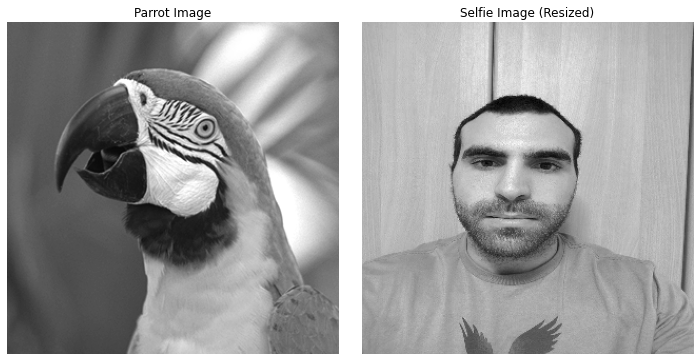

In [41]:
# 2.a
import cv2
import matplotlib.pyplot as plt

# Load the images
parrot_image = cv2.imread('parrot.png', cv2.IMREAD_GRAYSCALE)
selfie_image = cv2.imread('yours.jpg', cv2.IMREAD_GRAYSCALE)

# Resize the selfie to match the dimensions of the parrot image
selfie_resized = cv2.resize(selfie_image, (parrot_image.shape[1], parrot_image.shape[0]))

# Ensure images are in uint8 format
parrot_image = parrot_image.astype('uint8')
selfie_resized = selfie_resized.astype('uint8')

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Parrot Image")
plt.imshow(parrot_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Selfie Image (Resized)")
plt.imshow(selfie_resized, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

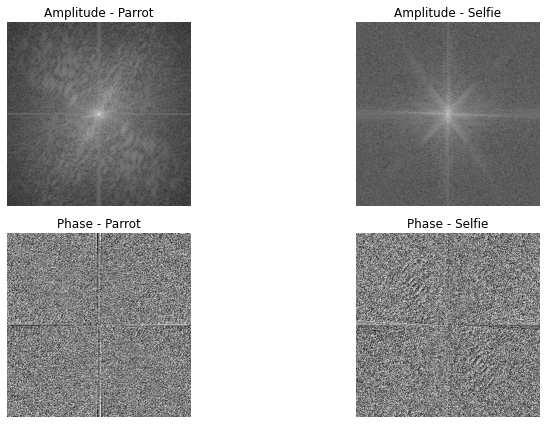

In [108]:
# 2.b
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the images again if needed
parrot_image = cv2.imread('parrot.png', cv2.IMREAD_GRAYSCALE).astype('float32')
selfie_image = cv2.imread('yours.jpg', cv2.IMREAD_GRAYSCALE).astype('float32')

# Resize the selfie image to match the parrot image
selfie_resized = cv2.resize(selfie_image, (parrot_image.shape[1], parrot_image.shape[0]))

# Perform 2D-DFT
fft_parrot = np.fft.fft2(parrot_image)
fft_selfie = np.fft.fft2(selfie_resized)

# Apply fftshift to bring low frequencies to the center
fft_parrot = np.fft.fftshift(fft_parrot)
fft_selfie = np.fft.fftshift(fft_selfie)

# Calculate amplitude and phase
amp_parrot = np.abs(fft_parrot)
phase_parrot = np.angle(fft_parrot)

amp_selfie = np.abs(fft_selfie)
phase_selfie = np.angle(fft_selfie)

# Display the amplitude images
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title("Amplitude - Parrot")
plt.imshow(np.log(1 + amp_parrot), cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Amplitude - Selfie")
plt.imshow(np.log(1 + amp_selfie), cmap='gray')
plt.axis('off')

# Display the phase images
plt.subplot(2, 2, 3)
plt.title("Phase - Parrot")
plt.imshow(phase_parrot, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Phase - Selfie")
plt.imshow(phase_selfie, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

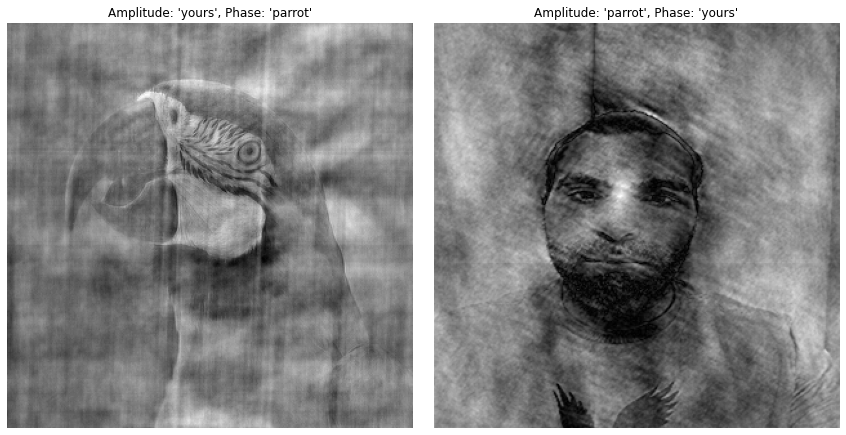

In [111]:
# 2.c
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the parrot and selfie images (ensure they are grayscale and resized as in Section 2.a)
parrot_image = cv2.imread('parrot.png', cv2.IMREAD_GRAYSCALE)
selfie_image = cv2.imread('yours.jpg', cv2.IMREAD_GRAYSCALE)
selfie_resized = cv2.resize(selfie_image, (parrot_image.shape[1], parrot_image.shape[0]))

# Compute the 2D-DFT of both images
fft_parrot = np.fft.fft2(parrot_image)
fft_selfie = np.fft.fft2(selfie_resized)

# Apply fftshift to bring low frequencies to the center
fft_parrot = np.fft.fftshift(fft_parrot)
fft_selfie = np.fft.fftshift(fft_selfie)

# Compute amplitude and phase for both images
amp_parrot = np.abs(fft_parrot)
phase_parrot = np.angle(fft_parrot)

amp_selfie = np.abs(fft_selfie)
phase_selfie = np.angle(fft_selfie)

# Create mixed images in the frequency domain
mixed_1 = amp_selfie * np.exp(1j * phase_parrot)  # Amplitude of 'yours' and phase of 'parrot'
mixed_2 = amp_parrot * np.exp(1j * phase_selfie)  # Amplitude of 'parrot' and phase of 'yours'

# Perform the inverse FFT to get the spatial domain images
result_1 = np.fft.ifft2(np.fft.ifftshift(mixed_1))
result_2 = np.fft.ifft2(np.fft.ifftshift(mixed_2))

# Take the magnitude to obtain real values
result_1_real = np.abs(result_1)
result_2_real = np.abs(result_2)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(result_1_real, cmap='gray')
plt.title("Amplitude: 'yours', Phase: 'parrot'")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_2_real, cmap='gray')
plt.title("Amplitude: 'parrot', Phase: 'yours'")
plt.axis('off')

plt.tight_layout()
plt.show()

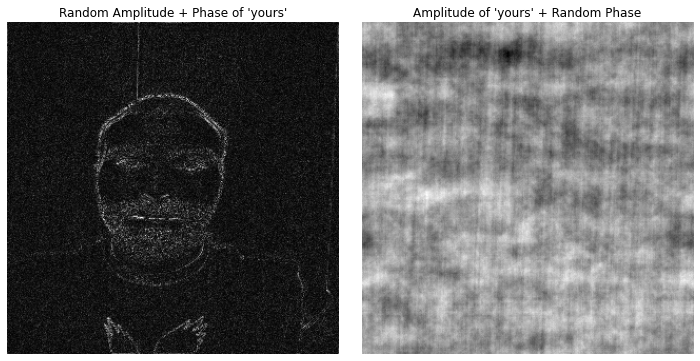

In [57]:
# 2.d
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load your previously resized grayscale images
parrot_image = cv2.imread('parrot.png', cv2.IMREAD_GRAYSCALE)
selfie_image = cv2.imread('yours.jpg', cv2.IMREAD_GRAYSCALE)
selfie_resized = cv2.resize(selfie_image, parrot_image.shape[::-1])

# Perform DFT on the resized selfie image
dft_selfie = np.fft.fftshift(np.fft.fft2(selfie_resized))
amplitude_selfie = np.abs(dft_selfie)
phase_selfie = np.angle(dft_selfie)

# Random amplitude (uniform distribution)
random_amplitude = np.random.uniform(low=0, high=np.max(amplitude_selfie), size=dft_selfie.shape)

# Random phase (uniform distribution between -pi and pi)
random_phase = np.random.uniform(low=-np.pi, high=np.pi, size=dft_selfie.shape)

# Image 1: Random amplitude + Phase of 'yours'
dft_random_amp = random_amplitude * np.exp(1j * phase_selfie)
image_random_amp = np.abs(np.fft.ifft2(np.fft.ifftshift(dft_random_amp)))

# Image 2: Amplitude of 'yours' + Random phase
dft_random_phase = amplitude_selfie * np.exp(1j * random_phase)
image_random_phase = np.abs(np.fft.ifft2(np.fft.ifftshift(dft_random_phase)))

# Plot the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Random Amplitude + Phase of 'yours'")
plt.imshow(image_random_amp, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Amplitude of 'yours' + Random Phase")
plt.imshow(image_random_phase, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

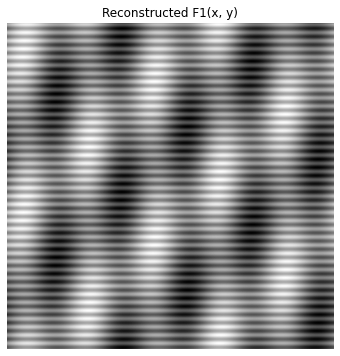

In [73]:
# 3.a
import numpy as np
import matplotlib.pyplot as plt

# Define the image size
size = 512

# Create a grid of x and y coordinates
x = np.arange(size)
y = np.arange(size)
X, Y = np.meshgrid(x, y)

# Define the frequencies
f_x = 5 / size  # Frequency in the x direction
f_y = 40 / size  # Frequency in the y direction
f_xy = 2 / size  # Frequency in the x + y direction

# Construct F1(x, y) using the given sine functions
F1 = (np.sin(2 * np.pi * f_x * X) +
      np.sin(2 * np.pi * f_y * Y) + 
      np.sin(2 * np.pi * f_xy * (X + Y)))

# Normalize the result to the range [0, 255]
F1_normalized = (F1 - F1.min()) / (F1.max() - F1.min()) * 255
F1_normalized = F1_normalized.astype(np.uint8)

# Display the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(F1_normalized, cmap='gray')
plt.title("Reconstructed F1(x, y)")
plt.axis('off')
plt.show()

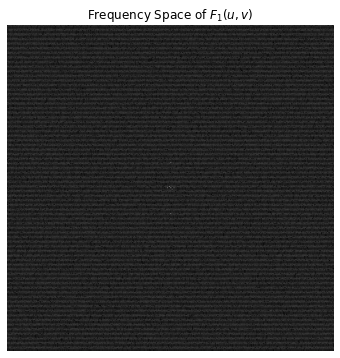

In [113]:
# 3.b
import numpy as np
import matplotlib.pyplot as plt

# Perform the 2D Fourier Transform
F1_frequency = np.fft.fft2(F1_normalized)
F1_frequency_shifted = np.fft.fftshift(F1_frequency)  # Shift the zero frequency component to the center
F1_magnitude_spectrum = 20 * np.log(np.abs(F1_frequency_shifted) + 1)  # Compute the magnitude spectrum

# Display the frequency space as a grayscale image
plt.figure(figsize=(6, 6))
plt.imshow(F1_magnitude_spectrum, cmap='gray')
plt.title("Frequency Space of $F_1(u, v)$")
plt.axis('off')
plt.show()

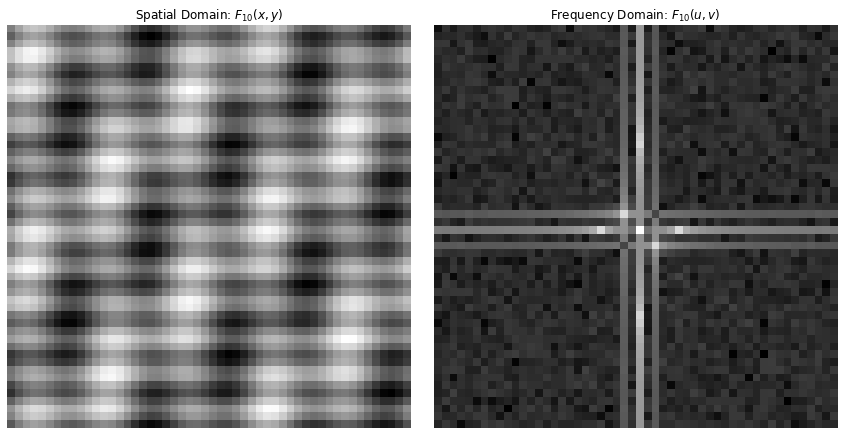

In [79]:
# 3.c
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling interval
sampling_interval = 10

# Downsample F1 to create F10
F10 = F1[::sampling_interval, ::sampling_interval]

# Normalize the downsampled image
F10_normalized = (F10 - F10.min()) / (F10.max() - F10.min()) * 255
F10_normalized = F10_normalized.astype(np.uint8)

# Perform Fourier Transform for F10
F10_frequency = np.fft.fft2(F10_normalized)
F10_frequency_shifted = np.fft.fftshift(F10_frequency)
F10_magnitude_spectrum = 20 * np.log(np.abs(F10_frequency_shifted) + 1)

# Plot F10 in spatial and frequency domains
plt.figure(figsize=(12, 6))

# Spatial domain
plt.subplot(1, 2, 1)
plt.imshow(F10_normalized, cmap='gray')
plt.title("Spatial Domain: $F_{10}(x, y)$")
plt.axis('off')

# Frequency domain
plt.subplot(1, 2, 2)
plt.imshow(F10_magnitude_spectrum, cmap='gray')
plt.title("Frequency Domain: $F_{10}(u, v)$")
plt.axis('off')

plt.tight_layout()
plt.show()

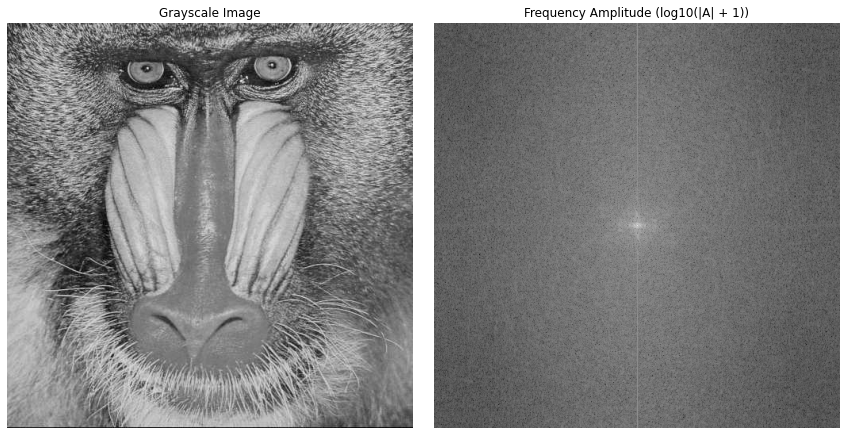

In [80]:
# 3.e
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale
image_path = 'Mandrill.jpg'
mandrill_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Perform the 2D Fourier Transform
mandrill_frequency = np.fft.fft2(mandrill_image)
mandrill_frequency_shifted = np.fft.fftshift(mandrill_frequency)

# Compute the magnitude spectrum in the required form
magnitude_spectrum = np.log10(np.abs(mandrill_frequency_shifted) + 1)

# Display the original grayscale image and the magnitude spectrum
plt.figure(figsize=(12, 6))

# Display the grayscale image
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(mandrill_image, cmap='gray')
plt.axis('off')

# Display the magnitude spectrum
plt.subplot(1, 2, 2)
plt.title("Frequency Amplitude (log10(|A| + 1))")
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

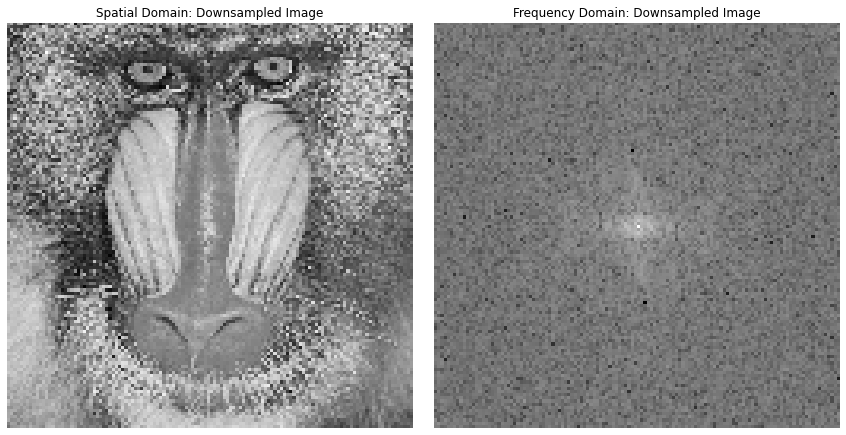

In [81]:
# 3.f
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale Mandrill image
image_path = 'Mandrill.jpg'
mandrill_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Down-sample the image to 128x128
downsampled_image = mandrill_image[::4, ::4]

# Normalize the downsampled image
downsampled_normalized = (downsampled_image - downsampled_image.min()) / (downsampled_image.max() - downsampled_image.min()) * 255
downsampled_normalized = downsampled_normalized.astype(np.uint8)

# Perform Fourier Transform on the downsampled image
downsampled_frequency = np.fft.fft2(downsampled_normalized)
downsampled_frequency_shifted = np.fft.fftshift(downsampled_frequency)

# Compute the magnitude spectrum for the downsampled image
downsampled_magnitude_spectrum = np.log10(np.abs(downsampled_frequency_shifted) + 1)

# Plot the downsampled image and its frequency domain
plt.figure(figsize=(12, 6))

# Spatial domain
plt.subplot(1, 2, 1)
plt.imshow(downsampled_normalized, cmap='gray')
plt.title("Spatial Domain: Downsampled Image")
plt.axis('off')

# Frequency domain
plt.subplot(1, 2, 2)
plt.imshow(downsampled_magnitude_spectrum, cmap='gray')
plt.title("Frequency Domain: Downsampled Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [82]:
# 4.a
import numpy as np

def bilinear_displacement(dx, dy, image):
    """
    Calculate the displacement of a pixel using a bilinear interpolation.

    :param dx: the displacement in the x direction. dx in range [0,1].
    :param dy: the displacement in the y direction. dy in range [0,1].
    :param image: The image on which we perform the cyclic displacement.
    :return: displaced_image: The new displaced image.
    """
    height, width = image.shape

    # Create a grid of coordinates
    x = np.arange(width)
    y = np.arange(height)
    X, Y = np.meshgrid(x, y)

    # Compute the new coordinates with cyclic displacement
    X_new = (X + dx) % width
    Y_new = (Y + dy) % height

    # Find the integer and fractional parts of the new coordinates
    X0 = np.floor(X_new).astype(int)
    Y0 = np.floor(Y_new).astype(int)

    X1 = (X0 + 1) % width
    Y1 = (Y0 + 1) % height

    alpha = X_new - X0  # Fractional part for x direction
    beta = Y_new - Y0   # Fractional part for y direction

    # Perform bilinear interpolation
    displaced_image = (
        (1 - alpha) * (1 - beta) * image[Y0, X0] +
        alpha * (1 - beta) * image[Y0, X1] +
        (1 - alpha) * beta * image[Y1, X0] +
        alpha * beta * image[Y1, X1]
    )

    return displaced_image

In [83]:
# 4.b
import numpy as np

def general_displacement(dx, dy, image):
    """
    Calculate the displacement of a pixel using a bilinear interpolation.

    :param dx: the displacement in the x direction.
    :param dy: the displacement in the y direction.
    :param image: The image on which we perform the cyclic displacement.
    :return: displaced_image: The new displaced image
    """
    height, width = image.shape

    # Create grid of coordinates for the original image
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

    # Compute the new coordinates with cyclic displacement
    new_x_coords = (x_coords + dx) % width
    new_y_coords = (y_coords + dy) % height

    # Get the integer and fractional parts of the new coordinates
    x0 = np.floor(new_x_coords).astype(int)
    x1 = (x0 + 1) % width
    y0 = np.floor(new_y_coords).astype(int)
    y1 = (y0 + 1) % height

    x_frac = new_x_coords - x0
    y_frac = new_y_coords - y0

    # Perform bilinear interpolation
    top_left = image[y0, x0]
    top_right = image[y0, x1]
    bottom_left = image[y1, x0]
    bottom_right = image[y1, x1]

    top = (1 - x_frac) * top_left + x_frac * top_right
    bottom = (1 - x_frac) * bottom_left + x_frac * bottom_right

    displaced_image = (1 - y_frac) * top + y_frac * bottom

    return displaced_image

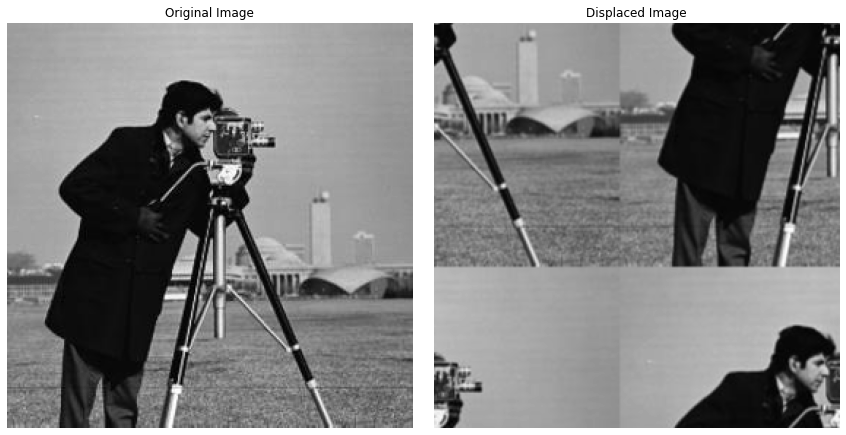

In [84]:
# 4.c
import cv2
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale
image_path = 'cameraman.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define the displacement values
dx = 150.7
dy = 110.4

# Use the general_displacement function to apply the displacement
displaced_image = general_displacement(dx, dy, image)

# Display the original and displaced images side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Displaced Image")
plt.imshow(displaced_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

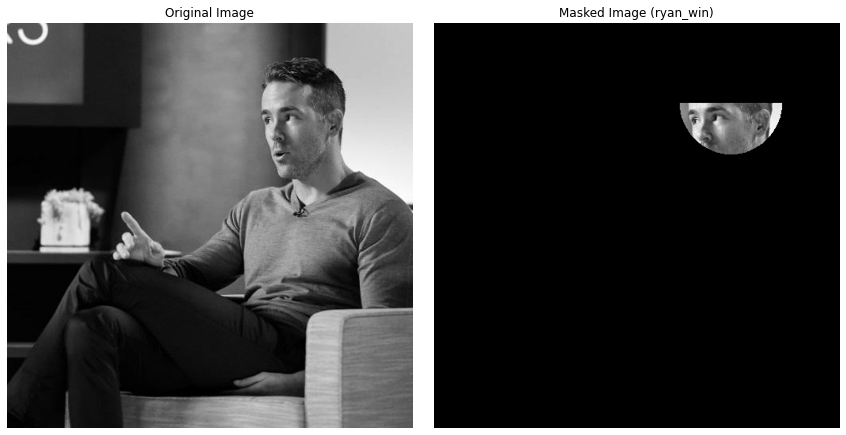

In [104]:
# 4.d
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale
image_path = 'Ryan.jpg'
ryan_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Create a mask with the same dimensions as the image
mask1 = np.zeros_like(ryan_image, dtype=np.uint8)

# Define the center and radius for the half-circle mask
height, width = ryan_image.shape
center = ((width // 23)*17, height // 5)  # Adjust the center explicitly to focus above Ryan's head
radius = height // 8  # Adjust the radius to fit the head area properly

# Draw a filled white half-circle on the mask
cv2.ellipse(mask1, center, (radius, radius), 0, 0, 180, 255, -1)

# Apply the mask to the image
ryan_win = cv2.bitwise_and(ryan_image, ryan_image, mask=mask1)

# Display the original image and the masked image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(ryan_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked Image (ryan_win)")
plt.imshow(ryan_win, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

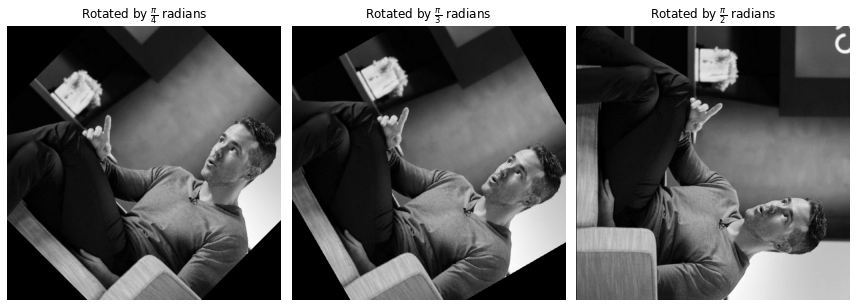

In [107]:
# 4.e
import numpy as np

def rotating_img(image, theta):
    """
    Calculate the displacement of a pixel using a bilinear interpolation.
    :param image: The image to rotate.
    :param theta: Angle of rotation in radians.
    :return: rotated_image: The new rotated image.
    """
    # Get image dimensions
    height, width = image.shape

    # Create an output image initialized with zeros
    rotated_image = np.zeros_like(image)

    # Compute the rotation matrix
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

    # Compute the center of the image
    center_x, center_y = width // 2, height // 2

    # Loop through each pixel in the output image
    for x in range(width):
        for y in range(height):
            # Shift the coordinates to center
            x_centered = x - center_x
            y_centered = y - center_y

            # Apply the inverse rotation matrix to get the original pixel location
            original_coords = np.dot(rotation_matrix.T, np.array([x_centered, y_centered]))
            original_x, original_y = original_coords + np.array([center_x, center_y])

            # Round to the nearest integer index
            original_x = int(np.round(original_x))
            original_y = int(np.round(original_y))

            # Check if the original coordinates are within bounds
            if 0 <= original_x < width and 0 <= original_y < height:
                rotated_image[y, x] = image[original_y, original_x]

    return rotated_image

# Example usage:
import cv2
import matplotlib.pyplot as plt

# Load the "ryan_win" masked image (as grayscale)
image_path = 'Ryan.jpg'
ryan_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply the function for different angles
angles = [np.pi / 4, np.pi / 3, np.pi / 2]
rotated_images = [rotating_img(ryan_image, theta) for theta in angles]

# Display the results with titles as fractions of π
plt.figure(figsize=(12, 8))
angle_titles = [r"$\frac{\pi}{4}$", r"$\frac{\pi}{3}$", r"$\frac{\pi}{2}$"]  # Titles for the angles
for i, (title, rotated) in enumerate(zip(angle_titles, rotated_images)):
    plt.subplot(1, 3, i + 1)
    plt.title(f"Rotated by {title} radians", fontsize=12)
    plt.imshow(rotated, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()